# QBUS2820 Assignment 2

**SID:** 510575452

In [2]:
# Importing Relevant Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from forecast import histogram, qq_plot, intervalforecast,fanchart
from sklearn.metrics import mean_squared_error

# Executive Summary

The project requirements aims to develop a time series model to forecast the Consumer Price Index (CPI) using data given to us that consists of 100 entries ranging from quarterly periods from March 1997 to December 2021.  The main objective is to predict the CPI values for March 2022 to December 2023 using multiple-step-ahead approaches.  Having accurate CPI forecasts is essential for economic and financial decision making.  

# Loading in Dataset

## Raw Data

In [3]:
CPI_train_data = pd.read_csv('data/CPI_train.csv', index_col='Quarter')

CPI_train_data

,CPI
Quarter,
Mar-97,94.5
Jun-97,93.1
Sep-97,95.4
Dec-97,96.3
Mar-98,96.0
...,...
Dec-20,125.3
Mar-21,123.6
Jun-21,124.5


**Note:**

- There are 100 entries


- Shows each quarter from 1997 - 2021


- Date layout: <abbreviation_of_month>-yy

# Data Cleaning

## Parsed Data

In [4]:
CPI_train_data.index = pd.to_datetime(
    CPI_train_data.index, format='%b-%y', errors='coerce')

CPI_train_data.index = CPI_train_data.index.to_period('Q')

CPI_train_data

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0
...,...
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5


Data is parsed so that the index of `CPI_Train_data` is converted into a quarterly period index format instead of `<abbreviation_of_month>-yy` format.  This will make the analysis consistent with the data provided and easier to apply to time series related libraries.

## Looking at Key Characteristics of the dataset

In [5]:
CPI_train_data.head()

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0


In [6]:
CPI_train_data.tail()

,CPI
Quarter,
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5
2021Q3,126.2
2021Q4,125.8


In [7]:
CPI_train_data.columns

Index(['CPI'], dtype='object')

In [8]:
CPI_train_data.shape

(100, 1)

### Removing null values

In [9]:
clean_CPI_train_data = CPI_train_data.dropna()

**Note:** even though there are no null values, it is great practice to always include this step in the data cleaning phase.

## Looking at the information of the dataset

In [10]:
clean_CPI_train_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 100 entries, 1997Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     100 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


## Looking at the description of the dataset

In [11]:
clean_CPI_train_data.describe()

,CPI
count,100.000000
mean,113.704000
std,9.187496
min,93.100000
25%,105.875000
50%,116.600000
75%,120.350000
max,126.200000


## Checking for Null Value

In [12]:
clean_CPI_train_data.isnull().sum()

CPI    0
dtype: int64

# EDA

## Looking at the trend of the data

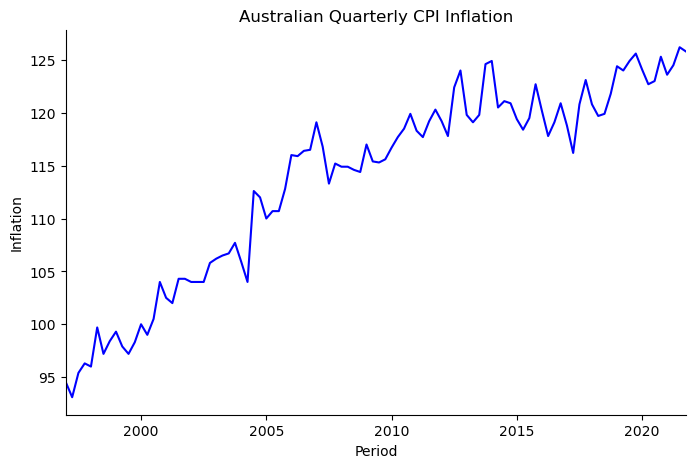

In [13]:
y = clean_CPI_train_data['CPI']

fig_CPI_initial, ax_CPI_intial = plt.subplots(figsize=(8, 5))
y.plot(color='b', ax=ax_CPI_intial)
ax_CPI_intial.set_xlabel('Period')
ax_CPI_intial.set_ylabel('Inflation')
ax_CPI_intial.set_title('Australian Quarterly CPI Inflation')
ax_CPI_intial.set_xticks([], minor=True)
sns.despine()
plt.show()

Based off the line graph for the Australian Quarterly CPI inflation, it shows a positive trend which indicates rise of prices overtime.  It also shows volatility of prices over the years but in particular in 2008, it shows the deflation of prices due to reduction in price of automative fuels (Treasury Ministers, 2021).

## Seasonal Plots

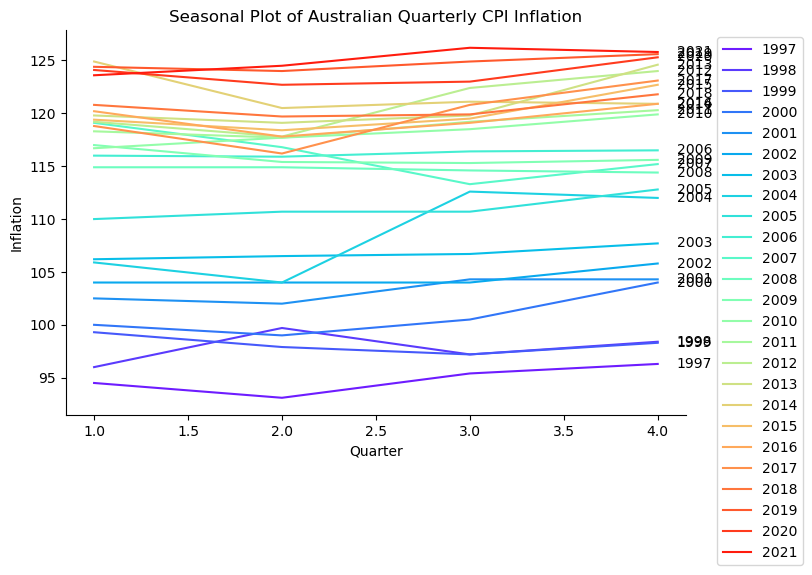

In [14]:
# Customize the colors for each year (example with a range of colors)
custom_palette = sns.color_palette("rainbow", len(
    clean_CPI_train_data.index.year.unique()))

fig_CPI_seasonal, ax_CPI_seasonal = plt.subplots(figsize=(8, 5))

# Plot the line plot with customized colors
sns.lineplot(
    x=clean_CPI_train_data.index.quarter,
    y=clean_CPI_train_data['CPI'],
    hue=clean_CPI_train_data.index.year,
    palette=custom_palette,
    ax=ax_CPI_seasonal
)

ax_CPI_seasonal.set_xlabel('Quarter')
ax_CPI_seasonal.set_ylabel('Inflation')
ax_CPI_seasonal.set_title('Seasonal Plot of Australian Quarterly CPI Inflation')

# Adding year labels at the end of each line
for year in clean_CPI_train_data.index.year.unique():
    year_data = clean_CPI_train_data[clean_CPI_train_data.index.year == year]
    ax_CPI_seasonal.text(
        # Position slightly to the right of the last point
        x=year_data.index.quarter.max() + 0.1,
        y=year_data['CPI'].iloc[-1],            # Last CPI value for the year
        s=str(year),                            # Year label
        verticalalignment='center'
    )

# Customize legend position
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
sns.despine()
plt.show()

As seen from the seasonal plot, we can identify that the CPI at the end of each year increases overtime from 1997-2021, however it shows in the middle period that 2006 ends higher than years 2007-2009.  Furthermore, we can see that there are major increases at the of the three group years (1997-1998), (2000-2003), (2004-2009), and (2010-2021).  Lastly, the main spikes occur during **Quarter 2** and **Quarter 3** for some of the years.

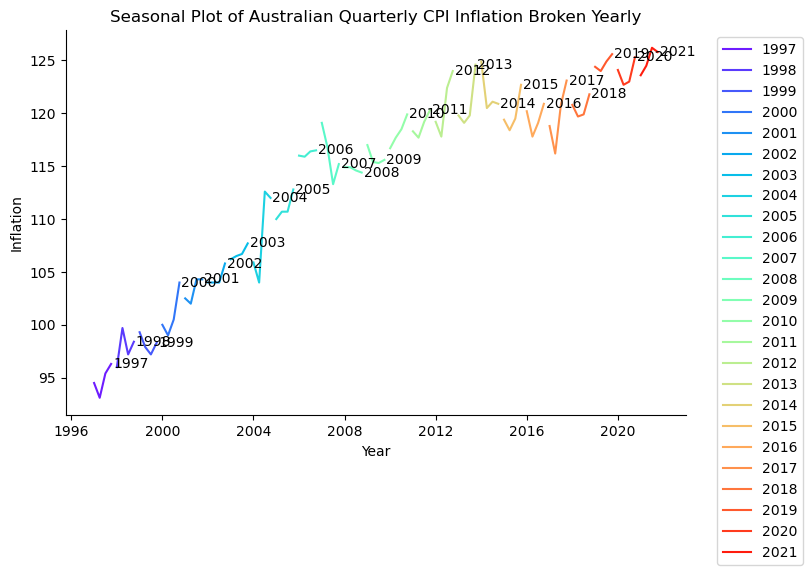

In [15]:
fig_CPI_seasonality_month_broken_yearly, ax_CPI_seasonality_broken_yearly = plt.subplots(figsize=(8, 5))

# Plot the line plot with customized colors
sns.lineplot(
    x=clean_CPI_train_data.index.to_timestamp(),
    y=clean_CPI_train_data['CPI'],
    hue=clean_CPI_train_data.index.year,
    palette=custom_palette,
    ax=ax_CPI_seasonality_broken_yearly
)

ax_CPI_seasonality_broken_yearly.set_xlabel('Year')
ax_CPI_seasonality_broken_yearly.set_ylabel('Inflation')
ax_CPI_seasonality_broken_yearly.set_title(
    'Seasonal Plot of Australian Quarterly CPI Inflation Broken Yearly')

# Adding year labels at the end of each line
for year in clean_CPI_train_data.index.year.unique():
    year_data = clean_CPI_train_data[clean_CPI_train_data.index.year == year]
    ax_CPI_seasonality_broken_yearly.text(
        # Position slightly to the right of the last point
        x=year_data.index.to_timestamp().max() + pd.DateOffset(months=1),
        y=year_data['CPI'].iloc[-1],           
        s=str(year),                            
        verticalalignment='center'
    )

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
sns.despine()
plt.show()

This graph breaks down the yearly trends in CPI data based on the seasonal patterns illustrated above. It distinctly highlights the individual inflation trend for each year from 1997 to 2021, providing a clear view of how CPI inflation has evolved across the entire period.


## ACF and PACF Plots

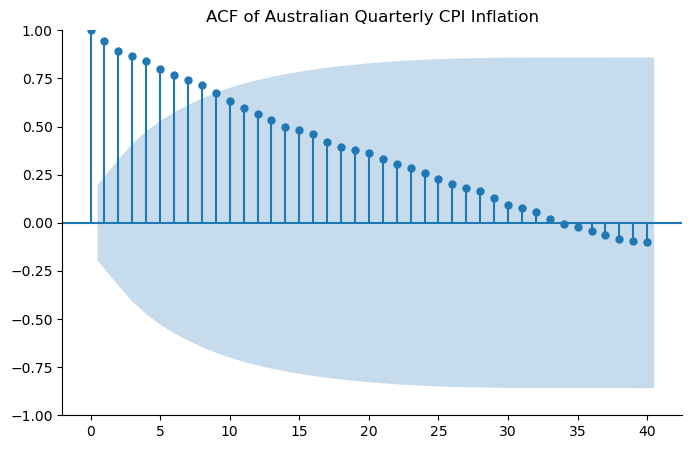

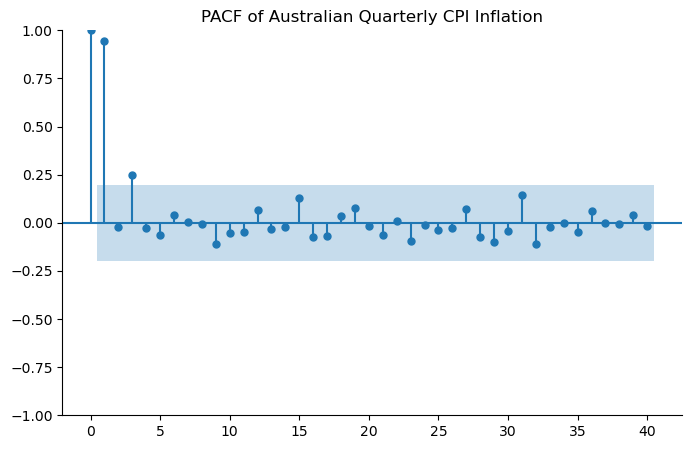

In [16]:
# ACF plots of the CPI data for 40 lags
fig_CPI_acf, ax_CPI_acf = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(y, lags=40, ax=ax_CPI_acf, alpha=0.05)
ax_CPI_acf.set_title('ACF of Australian Quarterly CPI Inflation')
sns.despine()
plt.show()

# PACF plots of the CPI data for 40 lags
fig_CPI_pacf, ax_CPI_pacf = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax_CPI_pacf, alpha=0.05)
ax_CPI_pacf.set_title('PACF of Australian Quarterly CPI Inflation')
sns.despine()
plt.show()

The ACF and PACF plots for Australian quarterly CPI inflation indicate a strong autoregressive structure, with significant autocorrelation at lower lags that gradually declines, pointing to a non-stationary time series. The ACF's slow decay suggests a potential trend in the data, while the PACF's rapid drop after lag 1 implies an autoregressive process of low order, likely AR(1). These findings suggest that the CPI inflation series may benefit from differencing and an ARIMA(1,1,0) model for further analysis. Seasonal effects could also be explored due to the economic nature of the data.

# Model Development

## Time Series Decomposition

In [52]:
window_size = 12    
decomposition = seasonal_decompose(y, model='additive', period=4, filt=np.repeat(1/window_size, window_size))

In [53]:
decomposition.seasonal.tail()

Quarter
2020Q4    0.894602
2021Q1    0.243466
2021Q2   -0.937595
2021Q3   -0.200473
2021Q4    0.894602
Freq: Q-DEC, Name: seasonal, dtype: float64

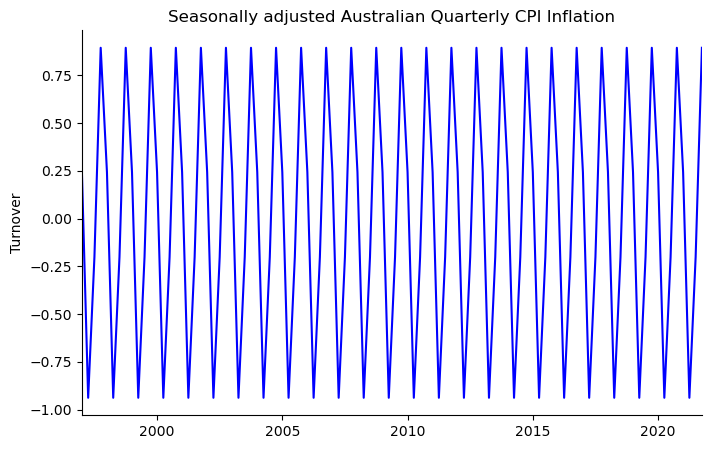

In [54]:
fig_seasonal_decomposition, ax_seasonal_decomposition = plt.subplots(
    figsize=(8, 5))
decomposition.seasonal.plot(color='blue', ax=ax_seasonal_decomposition)
ax_seasonal_decomposition.set_xlabel('')
ax_seasonal_decomposition.set_ylabel('Turnover')
ax_seasonal_decomposition.set_title(
    'Seasonally adjusted Australian Quarterly CPI Inflation')
ax_seasonal_decomposition.set_xticks([], minor=True)
sns.despine()
plt.show()

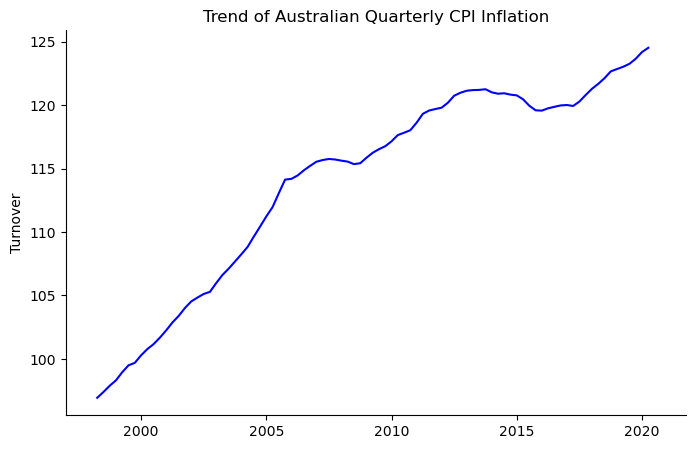

In [55]:
fig_trend_decomposition, ax_trend_decomposition = plt.subplots(figsize=(8, 5))
decomposition.trend.plot(color="blue", ax=ax_trend_decomposition)
ax_trend_decomposition.set_xlabel('')
ax_trend_decomposition.set_ylabel('Turnover')
ax_trend_decomposition.set_title('Trend of Australian Quarterly CPI Inflation')
ax_trend_decomposition.set_xticks([], minor=True)
sns.despine()
plt.show()

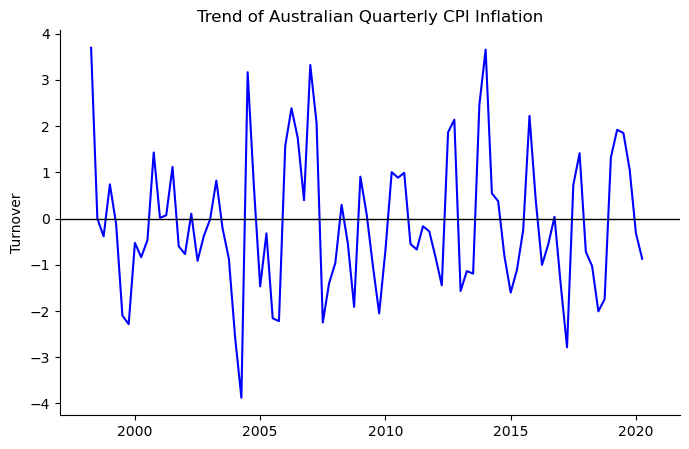

In [56]:
fig_resid_decomposition, ax_resid_decomposition = plt.subplots(figsize=(8, 5))
decomposition.resid.plot(color='blue', ax=ax_resid_decomposition)
ax_resid_decomposition.axhline(0, color='black', lw=1)
ax_resid_decomposition.set_xlabel('')
ax_resid_decomposition.set_ylabel('Turnover')
ax_resid_decomposition.set_title('Trend of Australian Quarterly CPI Inflation')
ax_resid_decomposition.set_xticks([], minor=True)
sns.despine()
plt.show()

## Testing for Stationary Points

**Hypothesis Testing** using **Augmented Dickey-Fuller**

**Formula:** 

\begin{align*}
\boldsymbol{\Delta} y_t = \boldsymbol{\alpha} + \boldsymbol{\beta} t + \boldsymbol{\gamma} y_{t-1} + \boldsymbol{\delta}_1 \boldsymbol{\Delta} y_{t-1} \dots + \boldsymbol{\delta}_{p-1} \boldsymbol{\Delta} y_{t-p+1} + \boldsymbol{\epsilon}_t,
\end{align*}


where $\boldsymbol{\alpha}$ is a constant term,  $\boldsymbol{\beta} t$ is the trend coefficient, $\boldsymbol{\gamma} y_{t-1}$ is the coefficient of the lagged level of time series, $\boldsymbol{\delta}_i$ are the coefficients of the lagged differences, $t$ is the time index, $p$ is the number of lags, and $\boldsymbol{\epsilon}_t$ is the error term  

$\boldsymbol{H_0}:$ The time series is non-stationary.


$\boldsymbol{H_A}:$ The time series is stationary.


**Threshold:**


$\boldsymbol{\alpha} = 0.05$

In [22]:
adf_test = adfuller(y, autolag='AIC')
print(f'ADF P-value: {round(adf_test[1], 4)}')

ADF P-value: 0.2314


Since the p-value $> 0.05$ ($\alpha$), we fail to reject the null hypothesis which suggests that the time series is non-stationary.  Hence, we will be using model smoothing techniques and SARIMA model to forecast the future predictions of the Australian CPI Inflation. 

## SARIMA Model

### First Order Differencing Data

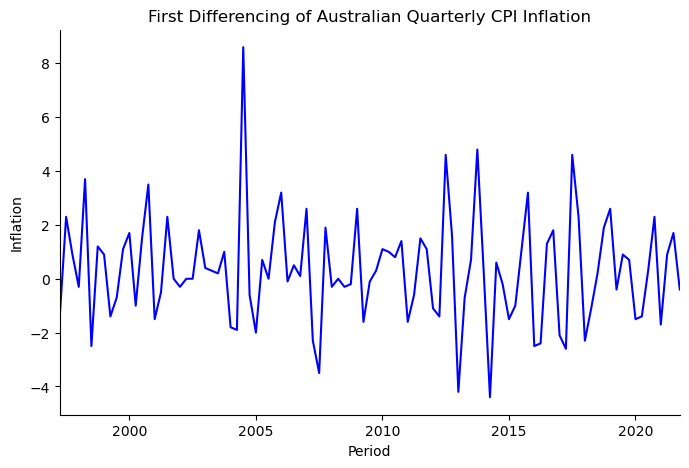

In [23]:
# 1st Differencing
y_diff = y.diff().dropna()

fig_diff, ax_diff = plt.subplots(figsize=(8, 5))
y_diff.plot(color='b', ax=ax_diff)
ax_diff.set_xlabel('Period')
ax_diff.set_ylabel('Inflation')
ax_diff.set_title('First Differencing of Australian Quarterly CPI Inflation')
ax_diff.set_xticks([], minor=True)
sns.despine()
plt.show()

In [24]:
adf_test = adfuller(y_diff, autolag='AIC')
print(f'ADF P-value: {round(adf_test[1], 4)}')

ADF P-value: 0.0007


Based from the first level differencing, we can clearly see that it has removed the linear trend that we saw in the time series decomposition trend graph and is now a stationary data based on the ADF test having a p-value of $\boldsymbol{0.0007}$.  We can now set parameter $d = 1$ for the ARIMA component.  Based on the seasonality component of SARIMA, we can set $D = 0$ since the time series decomposition graph already shows seasonality pattern.

We can now proceed to inspecting the ACF and PACF plot to determine the $p$ and $q$ parameters for ARIMA model and $P$ and $Q$ for the SARIMA component.

### Inspecting ACF and PACF plots

We can now proceed to inspecting the ACF and PACF plot to determine the $p$ and $q$ parameters for ARIMA model and $P$ and $Q$ for the SARIMA component.

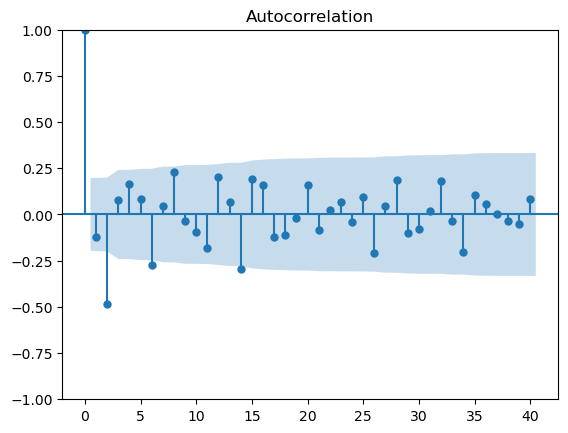

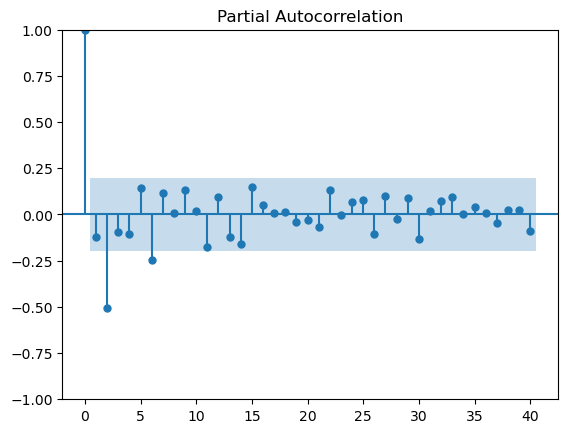

In [25]:
sm.graphics.tsa.plot_acf(y_diff, lags=40, alpha=0.05)
plt.show()

sm.graphics.tsa.plot_pacf(y_diff, lags=40, alpha=0.05)
plt.show()

In [26]:
sarima_model_aic = pm.auto_arima(y, seasonal=True, m=4,
                             information_criterion='aic', test='adf',
                             suppress_warnings=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=396.102, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=422.341, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=420.980, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=414.261, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=422.781, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=394.706, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=396.295, Time=0.03 sec
 ARIMA(2,1,2)(0,0,2)[4] intercept   : AIC=396.048, Time=0.13 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=394.186, Time=0.07 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=395.309, Time=0.14 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=397.790, Time=0.24 sec
 ARIMA(1,1,2)(1,0,0)[4] intercept   : AIC=394.774, Time=0.05 sec
 ARIMA(2,1,1)(1,0,0)[4] intercept   : AIC=394.663, Time=0.04 sec
 ARIMA(3,1,2)(1,0,0)[4] intercept   : AIC=398.695, Time=0.10 sec
 ARIMA(2,1,3)(1,0,0)[4] intercept   : AIC=398.6

In [27]:
sarima_model_aic.set_params()

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 0, 4),
      suppress_warnings=True)

In [28]:
sarima_model_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -190.093
Date:                            Fri, 01 Nov 2024   AIC                            394.186
Time:                                    14:58:10   BIC                            412.351
Sample:                                03-31-1997   HQIC                           401.536
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7280      0.242      3.002      0.003       0.253       1.203
ar.L1          0.0326      0.105      0.309      0.757      -0.174       0.239
ar.L2         -0.7778      0.103     -7.572      0.000      -0.979      -0.576
ma.L1         -0.2222      0.165     -1.348      0.178      -0.545       0.101
ma.L2          0.2659      0.180      1.477      0.140      -0.087       0.619
ar.S.L4       -0.3322      0.113     -2.951      0.003      -0.553      -0.112
sigma2         2.6974      0.379      7.126      0.000       1.956       3.439
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.35
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.99
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
sarima_model_bic = pm.auto_arima(y, seasonal=True, m=4,
                                 information_criterion='bic', test='adf',
                                 suppress_warnings=True, trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : BIC=416.863, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : BIC=427.532, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : BIC=431.360, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : BIC=424.642, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[4]             : BIC=425.376, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : BIC=412.871, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : BIC=411.865, Time=0.04 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : BIC=412.351, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : BIC=408.676, Time=0.02 sec
 ARIMA(1,1,2)(1,0,0)[4] intercept   : BIC=410.345, Time=0.04 sec
 ARIMA(1,1,2)(0,0,1)[4] intercept   : BIC=411.292, Time=0.03 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept   : BIC=411.266, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : BIC=407.290, Time=0.02 sec
 ARIMA(0,1,2)(1,0,0)[4] intercept   : BIC=410.796, Time=0.03 sec
 ARIMA(0,1,2)(0,0,1)[4] intercept   : BIC=411.1

In [30]:
sarima_model_bic.set_params()

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 4),
      suppress_warnings=True)

In [31]:
sarima_model_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -191.988
Date:                Fri, 01 Nov 2024   AIC                            393.976
Time:                        14:58:11   BIC                            406.951
Sample:                    03-31-1997   HQIC                           399.226
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3181      0.098      3.248      0.001       0.126       0.510
ma.L1         -0.2113      0.110     -1.921      0.055      -0.427       0.004
ma.L2         -0.5300      0.080     -6.594      0.000      -0.688      -0.372
ma.L3          0.2455      0.109      2.255      0.024       0.032       0.459
sigma2         2.8079      0.418      6.722      0.000       1.989       3.627
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                13.85
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.75
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
sarima_model = pm.ARIMA(order=(2, 1, 2), seasonal_order=(1, 0, 0, 4), solver='lbfgs', maxiter=200,
                        suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(y)
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -190.093
Date:                            Fri, 01 Nov 2024   AIC                            394.186
Time:                                    14:58:12   BIC                            412.351
Sample:                                03-31-1997   HQIC                           401.536
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7280      0.242      3.002      0.003       0.253       1.203
ar.L1          0.0326      0.105      0.309      0.757      -0.174       0.239
ar.L2         -0.7778      0.103     -7.572      0.000      -0.979      -0.576
ma.L1         -0.2222      0.165     -1.348      0.178      -0.545       0.101
ma.L2          0.2659      0.180      1.477      0.140      -0.087       0.619
ar.S.L4       -0.3322      0.113     -2.951      0.003      -0.553      -0.112
sigma2         2.6974      0.379      7.126      0.000       1.956       3.439
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.35
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.99
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

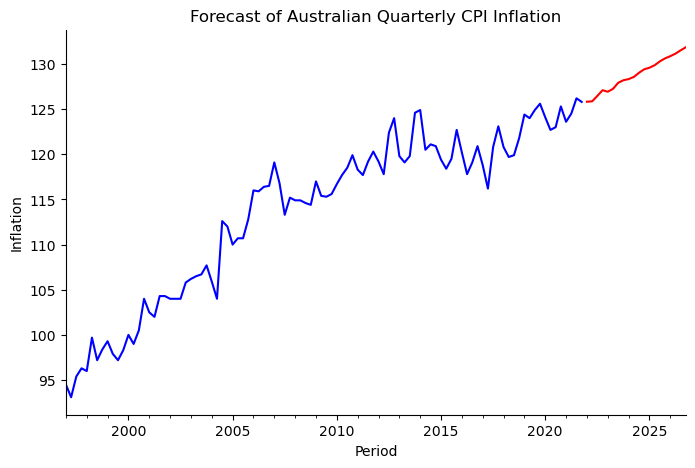

In [33]:
# Plot the forecast of the SARIMA model
fig_sarima_forecast, ax_sarima_forecast = plt.subplots(figsize=(8, 5))
y.plot(color='b', ax=ax_sarima_forecast)
# sarima_model.predict_in_sample().plot(color='r', ax=ax_sarima_forecast)
sarima_model.predict(n_periods=20).plot(color='r', ax=ax_sarima_forecast)
ax_sarima_forecast.set_xlabel('Period')
ax_sarima_forecast.set_ylabel('Inflation')
ax_sarima_forecast.set_title('Forecast of Australian Quarterly CPI Inflation')
sns.despine()
plt.show()

## Simple Exponential Smoothing 

In [34]:
simple_exponential_smoothing = SimpleExpSmoothing(y, initialization_method="estimated")
fitted_simple_exponential_smoothing = simple_exponential_smoothing.fit(optimized=True)
fitted_simple_exponential_smoothing.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,SimpleExpSmoothing,SSE,388.993
Optimized:,True,AIC,139.839
Trend:,None,BIC,145.049
Seasonal:,None,AICC,140.260
Seasonal Periods:,None,Date:,"Fri, 01 Nov 2024"
Box-Cox:,False,Time:,14:58:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6496116,alpha,True
initial_level,94.341806,l.0,True


## Holt Exponential Smoothing

In [35]:
holt_exponential_smoothing = Holt(y, initialization_method="estimated")
fitted_holt_exponential_smoothing = holt_exponential_smoothing.fit(optimized=True)
fitted_holt_exponential_smoothing.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,Holt,SSE,357.486
Optimized:,True,AIC,135.393
Trend:,Additive,BIC,145.813
Seasonal:,None,AICC,136.296
Seasonal Periods:,None,Date:,"Fri, 01 Nov 2024"
Box-Cox:,False,Time:,14:58:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4700246,alpha,True
smoothing_trend,0.000000,beta,True


### Plotting Smoothing Model Forecasts

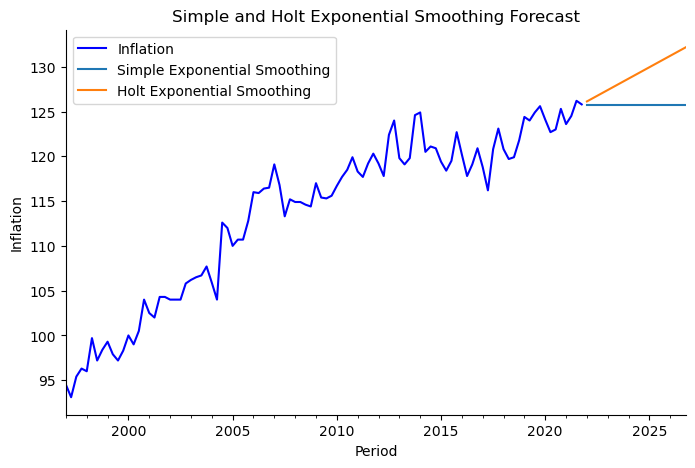

In [36]:
horizon = 20

smoothing_models = [fitted_simple_exponential_smoothing,
                    fitted_holt_exponential_smoothing]
model_names = ['Simple Exponential Smoothing',
               'Holt Exponential Smoothing']

fig_forecast, ax_forecast = plt.subplots(figsize=(8, 5))
y.plot(color='b', label='Inflation')

for model, name in zip(smoothing_models, model_names):
    pred = model.forecast(horizon)
    pred.plot(ax=ax_forecast, label=name)

ax_forecast.set_xlabel('Period')
ax_forecast.set_ylabel('Inflation')
ax_forecast.set_title('Simple and Holt Exponential Smoothing Forecast')
plt.legend(loc='best')
sns.despine()
plt.show()

## Holt-Winters Exponential Smoothing

In [37]:
ahw=ExponentialSmoothing(y, seasonal_periods=4, trend="add", seasonal="add", initialization_method="estimated").fit()
ahw.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,291.201
Optimized:,True,AIC,122.884
Trend:,Additive,BIC,143.726
Seasonal:,Additive,AICC,125.356
Seasonal Periods:,4,Date:,"Fri, 01 Nov 2024"
Box-Cox:,False,Time:,14:58:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5691148,alpha,True
smoothing_trend,4.7635e-10,beta,True


In [38]:
mhw = ExponentialSmoothing(y, seasonal_periods=12, trend="add",
                           seasonal="mul", initialization_method="estimated").fit()
mhw.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,276.717
Optimized:,True,AIC,133.782
Trend:,Additive,BIC,175.465
Seasonal:,Multiplicative,AICC,142.227
Seasonal Periods:,12,Date:,"Fri, 01 Nov 2024"
Box-Cox:,False,Time:,14:58:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5404220,alpha,True
smoothing_trend,0.000000,beta,True


In [39]:
mhw_damped = ExponentialSmoothing(y, seasonal_periods=12, trend="add",
                                  seasonal="mul", damped_trend=True, initialization_method="estimated").fit()
mhw_damped.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,269.035
Optimized:,True,AIC,132.967
Trend:,Additive,BIC,177.255
Seasonal:,Multiplicative,AICC,142.467
Seasonal Periods:,12,Date:,"Fri, 01 Nov 2024"
Box-Cox:,False,Time:,14:58:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4759881,alpha,True
smoothing_trend,2.1008e-12,beta,True


In [40]:
ahw_log = ExponentialSmoothing(np.log(y), seasonal_periods=12, trend="add", seasonal="add", initialization_method="estimated").fit()
ahw_log.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,0.022
Optimized:,True,AIC,-810.909
Trend:,Additive,BIC,-769.226
Seasonal:,Additive,AICC,-802.464
Seasonal Periods:,12,Date:,"Fri, 01 Nov 2024"
Box-Cox:,False,Time:,14:58:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5218593,alpha,True
smoothing_trend,0.0240859,beta,True


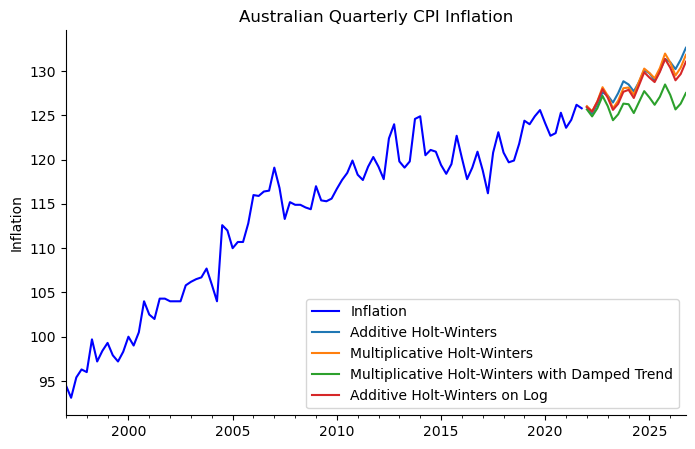

In [41]:
horizon = 20
holt_winters_models = [ahw, mhw, mhw_damped, ahw_log]
model_names = [
    'Additive Holt-Winters',
    'Multiplicative Holt-Winters',
    'Multiplicative Holt-Winters with Damped Trend',
    'Additive Holt-Winters on Log'
]

fig_comparison_hw, ax_comparison_hw = plt.subplots(figsize=(8, 5))
y.plot(color='b', label='Inflation')
for i, model in enumerate(holt_winters_models):
    pred = model.forecast(horizon)

    if model_names[i] == 'Additive Holt-Winters on Log':
        pred = np.exp(pred)

    pred.plot(label=model_names[i])

ax_comparison_hw.set_xlabel('')
ax_comparison_hw.set_ylabel('Inflation')
ax_comparison_hw.set_title('Australian Quarterly CPI Inflation')
plt.legend(loc='best')
sns.despine()
plt.show()

# Model Validation

### Splitting Data into Training and Validation Sets

In [77]:
ts = np.log(y)  

validation = y['2019Q1':].index
start = y.index.get_loc('2019Q1')

seasonal_walk_pred = []
simple_exponential_smoothing_pred = []
holt_exponential_smoothing_pred = []
ahw_pred = []
mhw_pred = []
mhw_damped_pred = []
ahw_log_pred = []
sarima_pred = []

for i in range(start, len(y)):
    seasonal_walk_pred.append(y[i-8])
    simple_exponential_smoothing_pred.append(fitted_simple_exponential_smoothing.forecast(8).values[-1])
    holt_exponential_smoothing_pred.append(fitted_holt_exponential_smoothing.forecast(8).values[-1])
    ahw_pred.append(ahw.forecast(8).values[-1])
    mhw_pred.append(mhw.forecast(8).values[-1])
    mhw_damped_pred.append(mhw_damped.forecast(8).values[-1])
    ahw_log_pred.append(np.exp(ahw_log.forecast(8).values[-1]))
    sarima_pred.append(sarima_model.predict(n_periods=8)[-1])

# Calculate the MSE for each model
mse_seasonal_walk = mean_squared_error(y[start:], seasonal_walk_pred)
mse_simple_exponential_smoothing = mean_squared_error(y[start:], simple_exponential_smoothing_pred)
mse_holt_exponential_smoothing = mean_squared_error(y[start:], holt_exponential_smoothing_pred)
mse_ahw = mean_squared_error(y[start:], ahw_pred)
mse_mhw = mean_squared_error(y[start:], mhw_pred)
mse_mhw_damped = mean_squared_error(y[start:], mhw_damped_pred)
mse_ahw_log = mean_squared_error(y[start:], ahw_log_pred)
mse_sarima = mean_squared_error(y[start:], sarima_pred)

# Create a DataFrame with the MSE values
mse_values = pd.DataFrame({
    'Model': ['Seasonal Walk', 'Simple Exponential Smoothing', 'Holt Exponential Smoothing',
              'Additive Holt-Winters', 'Multiplicative Holt-Winters',
              'Multiplicative Holt-Winters with Damped Trend', 'Additive Holt-Winters on Log', 'SARIMA'],
    'MSE': [mse_seasonal_walk, mse_simple_exponential_smoothing, mse_holt_exponential_smoothing,
            mse_ahw, mse_mhw, mse_mhw_damped, mse_ahw_log, mse_sarima]
})

# sort the values by MSE
mse_values = mse_values.sort_values(by='MSE')

# Remove the index

mse_values.reset_index(drop=True, inplace=True)

mse_values.index = mse_values.index + 1

mse_values

,Model,MSE
1,Additive Holt-Winters,1.222361
2,Multiplicative Holt-Winters,1.283160
3,Holt Exponential Smoothing,1.300542
4,Additive Holt-Winters on Log,1.793116
5,SARIMA,1.986102
6,Multiplicative Holt-Winters with Damped Trend,3.806596
7,Simple Exponential Smoothing,8.378853
8,Seasonal Walk,13.302500


In [68]:
# X = clean_CPI_train_data.drop('CPI', axis=1)
# y = clean_CPI_train_data['CPI']

# tss = TimeSeriesSplit(n_splits=5)

# for train_index, val_index in tss.split(X):
#     X_train, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [69]:
# # Simple Exponential Smoothing
# simple_exponential_smoothing = SimpleExpSmoothing(
#     y_train, initialization_method="estimated")

# fitted_simple_exponential_smoothing = simple_exponential_smoothing.fit(
#     optimized=True)

# # Holt Exponential Smoothing
# holt_exponential_smoothing = Holt(
#     y_train, initialization_method="estimated")

# fitted_holt_exponential_smoothing = holt_exponential_smoothing.fit(
#     optimized=True)

# # Holt-Winters Exponential Smoothing (Additive)
# ahw = ExponentialSmoothing(
#     y_train, seasonal_periods=4, trend="add", seasonal="add", initialization_method="estimated").fit()

# # Holt-Winters Exponential Smoothing (Multiplicative)

# mhw = ExponentialSmoothing(
#     y_train, seasonal_periods=4, trend="add", seasonal="mul", initialization_method="estimated").fit()

# # Holt-Winters Exponential Smoothing (Multiplicative with Damped Trend)
# mhw_damped = ExponentialSmoothing(
#     y_train, seasonal_periods=4, trend="add", seasonal="mul", damped_trend=True, initialization_method="estimated").fit()

# # Holt-Winters Exponential Smoothing (Additive on Log)
# ahw_log = ExponentialSmoothing(
#     np.log(y_train), seasonal_periods=4, trend="add", seasonal="add", initialization_method="estimated").fit()

# # SARIMA Model
# sarima_model = pm.ARIMA(order=(0, 1, 3), seasonal_order=(0, 0, 0, 4), solver='lbfgs', maxiter=200,
#                         suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(y_train)



# # Calculate MSE

# # Simple Exponential Smoothing
# y_pred_simple_exponential_smoothing = fitted_simple_exponential_smoothing.forecast(
#     len(y_val))
# mse_simple_exponential_smoothing = mean_squared_error(
#     y_val, y_pred_simple_exponential_smoothing).round(4)

# # Holt Exponential Smoothing
# y_pred_holt_exponential_smoothing = fitted_holt_exponential_smoothing.forecast(
#     len(y_val))
# mse_holt_exponential_smoothing = mean_squared_error(
#     y_val, y_pred_holt_exponential_smoothing).round(4)

# # Holt-Winters Exponential Smoothing (Additive)
# y_pred_awh = ahw.forecast(len(y_val))
# mse_ahw = mean_squared_error(y_val, y_pred_awh).round(4)

# # Holt-Winters Exponential Smoothing (Multiplicative)
# y_pred_mhw = mhw.forecast(len(y_val))
# mse_mhw = mean_squared_error(y_val, y_pred_mhw).round(4)

# # Holt-Winters Exponential Smoothing (Multiplicative with Damped Trend)
# y_pred_mhw_damped = mhw_damped.forecast(len(y_val))
# mse_mhw_damped = mean_squared_error(y_val, y_pred_mhw_damped).round(4)

# # Holt-Winters Exponential Smoothing (Additive on Log)
# y_pred_ahw_log = np.exp(ahw_log.forecast(len(y_val)))
# mse_ahw_log = mean_squared_error(y_val, y_pred_ahw_log).round(4)

# # SARIMA Model
# y_pred_sarima = sarima_model.predict(n_periods=len(y_val))
# mse_sarima = mean_squared_error(y_val, y_pred_sarima).round(4)


# # Create a dataframe to store the MSE of all the models
# mse = pd.DataFrame({'Smoothing Model': ['Simple Exponential Smoothing',
#                               'Holt Exponential Smoothing', 'Holt-Winters (Additive)',
#                               'Holt-Winters (Multiplicative)',
#                               'Holt-Winters (Multiplicative with Damped Trend)',
#                               'Holt-Winters (Additive on Log)', 'SARIMA'],
#                     'MSE': [mse_simple_exponential_smoothing, mse_holt_exponential_smoothing, mse_ahw,
#                             mse_mhw, mse_mhw_damped, mse_ahw_log, mse_sarima]})
# # Arrange the dataframe in descending order of MSE
# mse = mse.sort_values(by='MSE', ascending=False)

# # How to remove the index column

# mse.reset_index(drop=True, inplace=True)

# mse.index = mse.index + 1

# mse

,Smoothing Model,MSE
1,Simple Exponential Smoothing,6.8555
2,Holt-Winters (Multiplicative with Damped Trend),5.0428
3,Holt-Winters (Additive on Log),2.8117
4,Holt Exponential Smoothing,2.2416
5,Holt-Winters (Multiplicative),1.9107
6,Holt-Winters (Additive),1.9091
7,SARIMA,1.6635


# Picking Best Smoothing Model

In [44]:
best_model = ExponentialSmoothing(
    y, seasonal_periods=4, trend="add", seasonal="mul", damped_trend=True, initialization_method="estimated").fit()

horizon = 8

test = pd.period_range(
    start=y.index[-1] + 1, periods=horizon, freq='Q')

pred = pd.Series(
    best_model.forecast(horizon), index=test).round(4)

pred.index = pred.index.strftime('%b-%y')

CPI_forecast = pd.DataFrame(pred, columns=['CPI'])
CPI_forecast.index.name = 'Quarter'
CPI_forecast.to_csv('CPI_forecast.csv')

CPI_forecast

,CPI
Quarter,
Mar-22,125.6287
Jun-22,124.5154
Sep-22,125.4737
Dec-22,126.7561
Mar-23,126.1091
Jun-23,124.9833
Sep-23,125.9370
Dec-23,127.2162


# Code Chunk to Run Tests for Predictions

In [45]:
# CPI_test = pd.read_csv('CPI_test.csv')
# test_error = mean_squared_error(CPI_test['CPI'], CPI_forecast['CPI'])
# print (test_error)

# References

Treasury Ministers (2021) December 2008 Consumer Price Index, December 2008 Consumer Price Index | Treasury Ministers. Treasury Ministers. Available at: https://ministers.treasury.gov.au/ministers/wayne-swan-2007/media-releases/december-2008-consumer-price-index#:~:text=The%20fall%20in%20the%20December,the%20latter%20part%20of%202008. (Accessed: 22 October 2024).